In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1149557133317460915, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10945478656
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4109204534281741824
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

In [3]:
from utils import *

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

In [4]:
random_state = 42

In [5]:
ids_train = load_array("data/array/ids_train")
X_train_ = load_array("data/array/X_train")
y_train_ = load_array("data/array/y_train").astype(np.bool)
strata_train = load_array("data/array/strata_train")
# ids_test = load_array("data/test_ids")
# X_test = load_array("data/x_test")

In [6]:
im_width = X_train_.shape[1]
im_height = X_train_.shape[2]
im_chan = X_train_.shape[3]

In [7]:
X_train_.shape, y_train_.shape, im_width, im_height, im_chan

((4000, 128, 128, 1), (4000, 128, 128, 1), 128, 128, 1)

## Data Augmentation

We flip the images along the y axis

In [8]:
X_train_ = np.append(X_train_, [np.fliplr(x) for x in X_train_], axis=0)
y_train_ = np.append(y_train_, [np.fliplr(x) for x in y_train_], axis=0)

In [9]:
strata_train = np.append(strata_train, strata_train)

In [10]:
X_train_.shape, y_train_.shape, strata_train.shape

((8000, 128, 128, 1), (8000, 128, 128, 1), (8000,))

## Train/valid slip

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_,
    y_train_,
    test_size=0.2, stratify=strata_train, random_state=random_state)

In [12]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6400, 128, 128, 1),
 (1600, 128, 128, 1),
 (6400, 128, 128, 1),
 (1600, 128, 128, 1))

## Model

Now we define the actual Unet model

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [14]:
def build_model(input_layer, start_neurons=8, dropout=False):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    if dropout:
        pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    if dropout:
        pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    if dropout:
        pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    if dropout:
        pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    if dropout:
        uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    if dropout:
        uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    if dropout:
        uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    if dropout:
        uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    if dropout:
        uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [15]:
inputs = Input((im_height, im_width, im_chan))
in_ = Lambda(lambda x: x / 255) (inputs)

In [16]:
output_layer = build_model(in_, start_neurons=8)

In [17]:
model = Model(inputs, output_layer)

In [18]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[mean_iou])

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  80          lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_poolin

In [20]:
model_checkpoint = ModelCheckpoint("models/07-30/unet2-{epoch:02d}.model", verbose=1, mode='max', save_best_only=False)
early_stopping = EarlyStopping(patience=100, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
tensorboard = TensorBoard(log_dir='./models/07-30/tensorboard')


In [21]:
epochs = 100
batch_size = 128

In [22]:
results = model.fit(X_train, y_train,
                    validation_data=[X_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping, tensorboard])

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 27s 4ms/step - loss: 0.6042 - mean_iou: 0.3722 - val_loss: 0.5548 - val_mean_iou: 0.3781

Epoch 00001: saving model to models/07-30/unet2-01.model
Epoch 2/100
6400/6400 [==============================] - 21s 3ms/step - loss: 0.5227 - mean_iou: 0.3784 - val_loss: 0.4786 - val_mean_iou: 0.3780

Epoch 00002: saving model to models/07-30/unet2-02.model
Epoch 3/100
6400/6400 [==============================] - 21s 3ms/step - loss: 0.4367 - mean_iou: 0.3780 - val_loss: 0.3974 - val_mean_iou: 0.3780

Epoch 00003: saving model to models/07-30/unet2-03.model
Epoch 4/100
6400/6400 [==============================] - 21s 3ms/step - loss: 0.3868 - mean_iou: 0.3784 - val_loss: 0.4041 - val_mean_iou: 0.3812

Epoch 00004: saving model to models/07-30/unet2-04.model
Epoch 5/100
6400/6400 [==============================] - 21s 3ms/step - loss: 0.3654 - mean_iou: 0.3841 - val_loss: 0.3601 - val_mean_io

## Check the predictions

In [27]:
pred_valid = model.predict(X_valid, verbose=1)

1600/1600 [==============================] - 2s 1ms/step


In [28]:
pred_train.shape

(6400, 128, 128, 1)

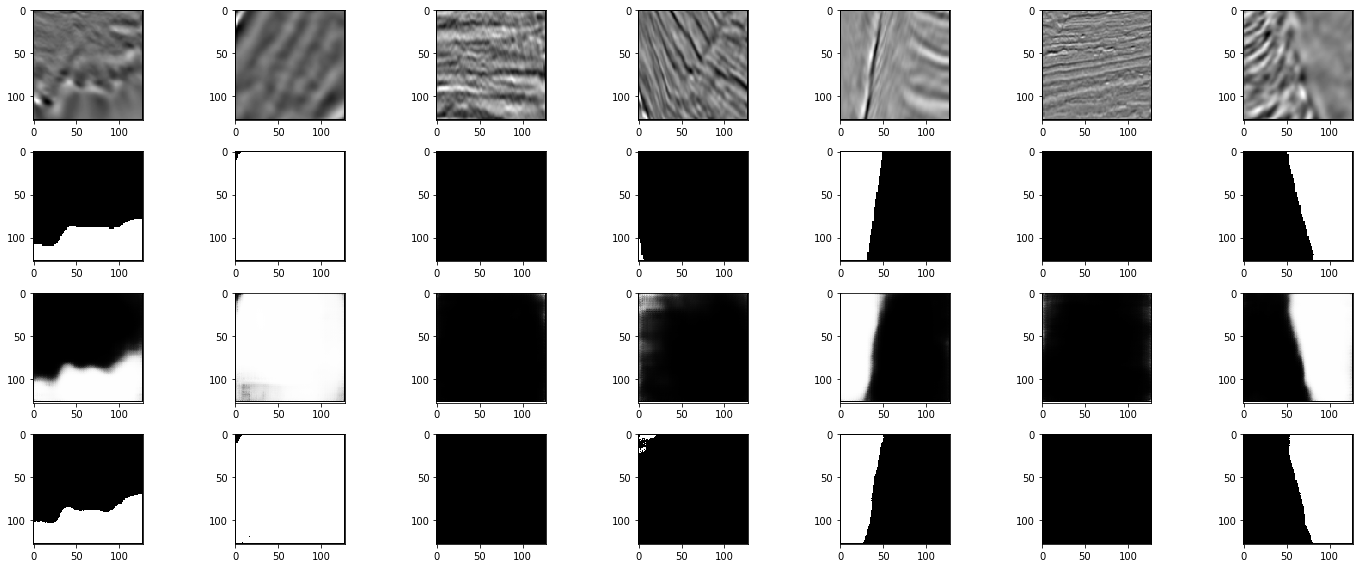

In [35]:
plot_arrays(X_valid, y_valid, pred_valid, pred_valid > 0.55, n=7, figsize=(20, 8))